In [1]:
#Here we are preprocessing all the anat and func data. 
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ,get_json_from_file

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob
from scipy.ndimage import zoom
import shutil


import ants
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json

from IPython.display import display, HTML


In [2]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

Gtk-Message: 10:14:32.787: Failed to load module "canberra-gtk-module"

(ipykernel_launcher.py:710): Gtk-CRITICAL **: 10:14:32.897: gtk_window_resize: assertion 'height > 0' failed


In [3]:
#Import paths and creation of files for preprocessing
import subprocess
from fsl.wrappers import mcflirt

dataset_id = 'ds000171'
subject = '01'

subject_dir = 'sub-control{}'.format(subject)

sample_path = "/home/jovyan/data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)

###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################

#Creating pre processed path
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(deriv_root)
#Path to the anatomical raw data
anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
bet_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')
#Path to the functional raw data
fmap_path = op.join(bids_root, 'sub-control01', 'func')
#Path to preprocess data : 
preproc_data_path = op.join(preproc_root, 'sub-control01', 'func', 'concat_fd_corrected.nii.gz')

In [4]:
import nibabel as nib
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [5]:
img = nib.load(preproc_data_path)
data = img.get_fdata()
timepoints = data.shape[-1]
reshaped_data = data.reshape(-1, timepoints).T

In [6]:
anat_img = nib.load(anatomical_path)
anat_data = anat_img.get_fdata()

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(reshaped_data)

In [8]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(normalized_data)
labels = kmeans.labels_

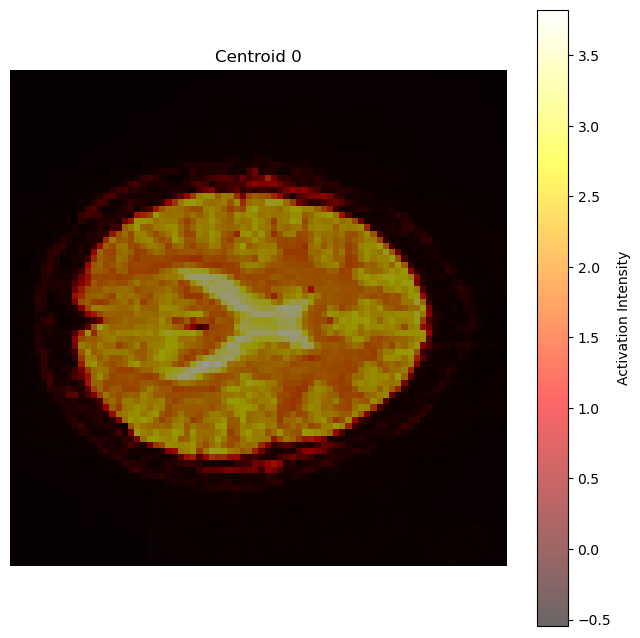

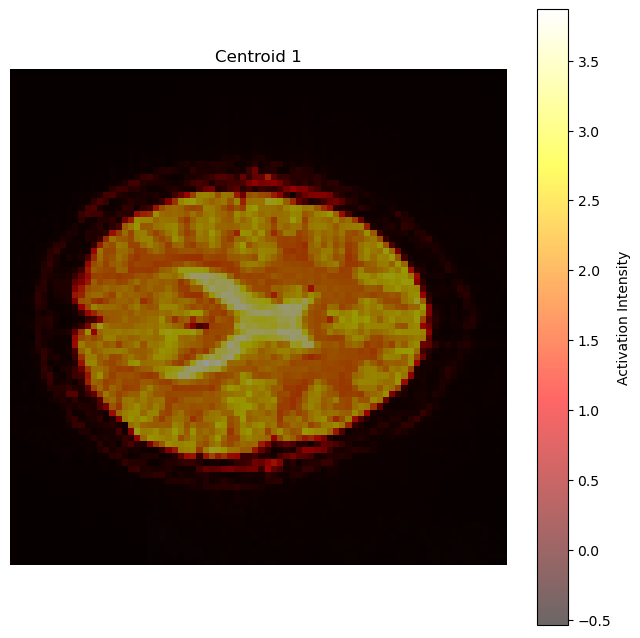

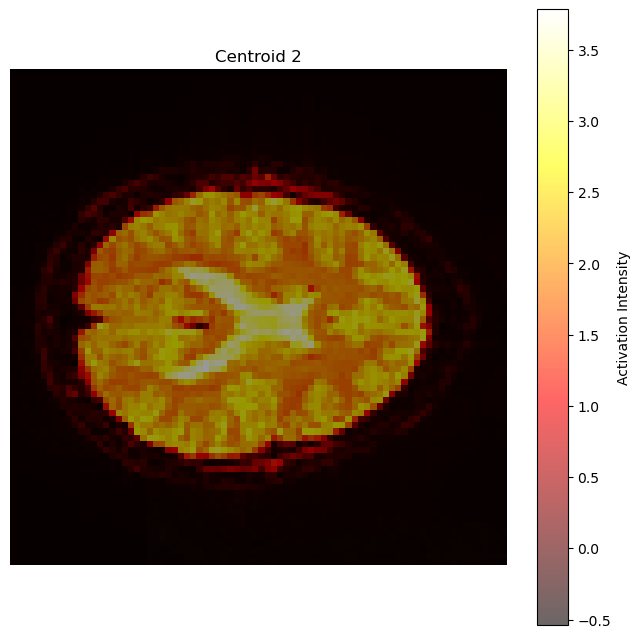

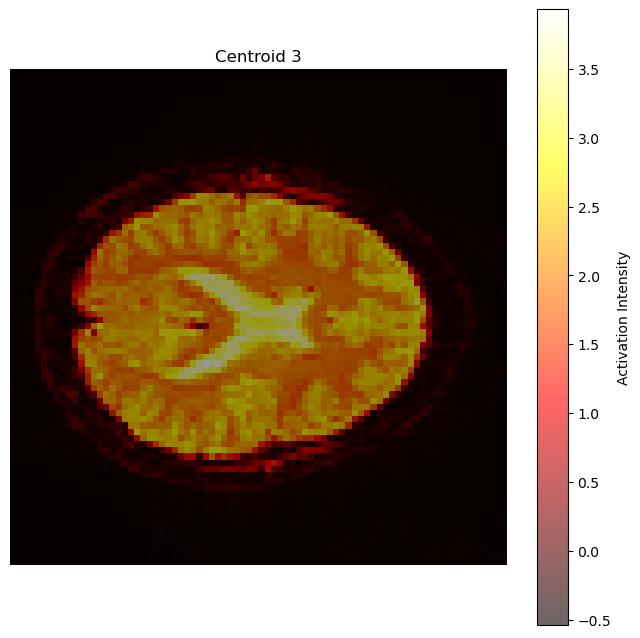

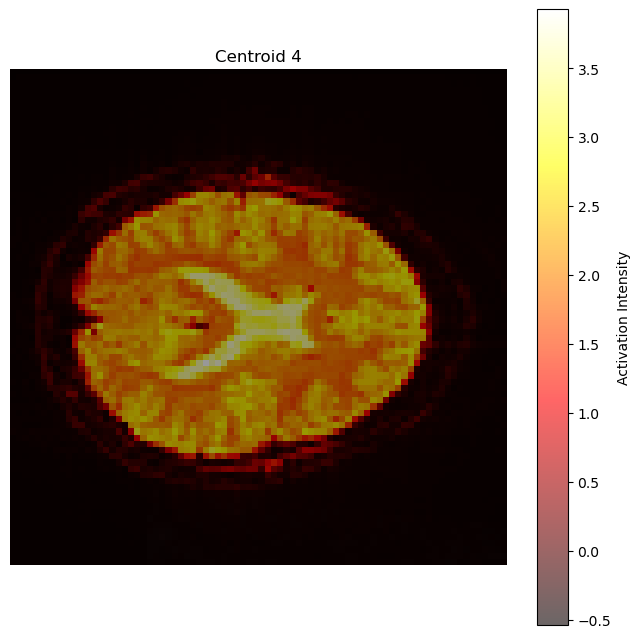

In [9]:
# Extraire les centroides
centroids = kmeans.cluster_centers_
centroids_3d = scaler.inverse_transform(centroids).T.reshape(data.shape[:-1] + (k,))

# Superposer chaque centroïde sur une coupe axiale de l’anatomie
for i in range(k):
    centroid_img = centroids_3d[..., i]  # Centroid pour le cluster i
    
    # Choisir une coupe axiale au milieu de l'image
    slice_index = centroid_img.shape[2] // 2
    axial_centroid_slice = centroid_img[:, :, slice_index]  # Couche du centroïde
    axial_anat_slice = anat_data[:, :, slice_index]  # Couche de l'anatomie
    
    plt.figure(figsize=(8, 8))
    plt.imshow(axial_anat_slice, cmap='gray')  # Afficher l'anatomie en fond
    plt.imshow(axial_centroid_slice, cmap="hot", alpha=0.6)  # Superposer le centroïde avec transparence
    plt.title(f"Centroid {i}")
    plt.colorbar(label="Activation Intensity")
    plt.axis('off')  # Optionnel : enlever les axes pour une meilleure visualisation
    plt.show()

In [10]:
print(reshaped_data.shape)

(307, 320000)
